# 02 – Structural Properties of the Collaboration Network

In this notebook we analyze structural properties of the collaboration network used in the link prediction project.

Goals:

1. Rebuild the undirected collaboration graph from the edge list.
2. Study the degree distribution (including CCDF in log–log scale).
3. Compute clustering coefficients (global and local distribution).
4. Measure degree assortativity.
5. Analyze connected components and the giant component.
6. Approximate shortest-path lengths and centrality for key nodes.

These network properties provide additional context for interpreting the performance of GNN-based link prediction models.

In [18]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

# Paths
base_dir = Path("..")
data_dir = base_dir / "data"
edge_list_path = data_dir / "collaboration.edgelist.txt"

print("Base dir:", base_dir.resolve())
print("Data dir:", data_dir.resolve())
print("Edge list path:", edge_list_path)

if not edge_list_path.exists():
    raise FileNotFoundError(f"Edge list not found at: {edge_list_path}")

Base dir: /workspace
Data dir: /workspace/data
Edge list path: ../data/collaboration.edgelist.txt


## 1. Load and clean the edge list

The file is a whitespace-separated edge list with two integer columns `(u, v)` representing undirected co-authorship relations. We remove self-loops, enforce a canonical ordering `(u < v)` and drop duplicate edges, as in the main training pipeline.

In [19]:
df_edges = pd.read_csv(edge_list_path, sep=r"\s+", header=None, names=["u", "v"])
print("Raw edge list shape:", df_edges.shape)
df_edges.head()

Raw edge list shape: (93439, 2)


,u,v
0,0,1680
1,0,6918
2,0,19642
3,1,4131
4,1,5645


In [20]:
# Remove self-loops
df_edges = df_edges[df_edges["u"] != df_edges["v"]].copy()

# Canonical form for undirected edges
u_min = np.minimum(df_edges["u"].values, df_edges["v"].values)
v_max = np.maximum(df_edges["u"].values, df_edges["v"].values)
df_edges["u"] = u_min
df_edges["v"] = v_max

# Drop duplicates
df_edges = df_edges.drop_duplicates().reset_index(drop=True)

print("After cleaning:")
print("  Number of edges:", len(df_edges))
print("  Min node ID:", df_edges[["u", "v"]].values.min())
print("  Max node ID:", df_edges[["u", "v"]].values.max())

df_edges.head()

After cleaning:
  Number of edges: 93439
  Min node ID: 0
  Max node ID: 23132


,u,v
0,0,1680
1,0,6918
2,0,19642
3,1,4131
4,1,5645


## 2. Basic graph construction and summary

We now build a NetworkX undirected graph and verify the number of nodes and edges. This should match the values reported in the paper (e.g., 23,133 nodes and 93,439 edges, depending on the dataset version).

In [21]:
G = nx.Graph()
G.add_edges_from(df_edges[["u", "v"]].itertuples(index=False, name=None))

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(G)
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Graph with 23133 nodes and 93439 edges
Number of nodes: 23133
Number of edges: 93439


## 3. Degree distribution

We examine the degree distribution in more detail. Collaboration networks are often highly skewed: most authors have few collaborators, while a small fraction have many.

We will:

- Compute basic statistics of node degrees.
- Plot a histogram (linear scale).
- Plot the complementary cumulative distribution function (CCDF) in log–log scale.

In [22]:
# Degree sequence
degrees = dict(G.degree())
deg_values = np.array(list(degrees.values()))

deg_stats = pd.Series(deg_values, name="degree").describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]
)
deg_stats

count    23133.000000
mean         8.078416
std         10.627266
min          1.000000
25%          3.000000
50%          5.000000
75%          9.000000
90%         18.000000
99%         50.000000
max        279.000000
Name: degree, dtype: float64

### 3.1 Histogram of degrees (linear scale)

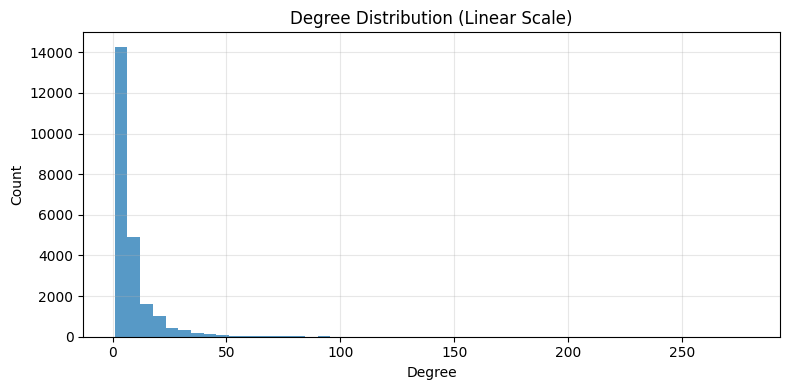

In [23]:
plt.figure(figsize=(8, 4))
plt.hist(deg_values, bins=50, alpha=0.75)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution (Linear Scale)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 CCDF of degree distribution (log–log scale)

The complementary cumulative distribution function (CCDF) shows $P(\text{degree} \geq k)$ as a function of $k$. Plotting this in log–log scale is a common way to inspect heavy-tailed behavior in complex networks.

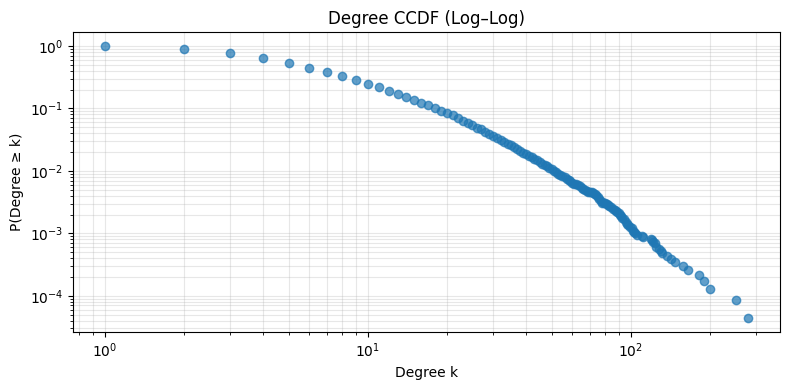

In [24]:
# Compute CCDF
deg_sorted = np.sort(deg_values)
unique_deg = np.unique(deg_sorted)
ccdf = []
for k in unique_deg:
    p = np.mean(deg_values >= k)
    ccdf.append(p)

plt.figure(figsize=(8, 4))
plt.loglog(unique_deg, ccdf, marker="o", linestyle="none", alpha=0.7)
plt.xlabel("Degree k")
plt.ylabel("P(Degree ≥ k)")
plt.title("Degree CCDF (Log–Log)")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Clustering coefficient

The clustering coefficient measures the tendency of neighbors of a node to be connected. Collaboration networks are typically highly clustered due to triadic closure (co-authors of a researcher are more likely to collaborate with each other).

We compute:

- Global average clustering coefficient.
- Distribution of local clustering coefficients.

In [25]:
# Average clustering coefficient
avg_clustering = nx.average_clustering(G)
print("Average clustering coefficient (whole graph):", avg_clustering)

Average clustering coefficient (whole graph): 0.6334130270820648


In [26]:
# Local clustering coefficients
clustering_dict = nx.clustering(G)
clustering_values = np.array(list(clustering_dict.values()))

pd.Series(clustering_values, name="clustering").describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]
)

count    23133.000000
mean         0.633413
std          0.381393
min          0.000000
25%          0.290909
50%          0.700000
75%          1.000000
90%          1.000000
99%          1.000000
max          1.000000
Name: clustering, dtype: float64

### 4.1 Histogram of local clustering coefficients

We visualize how clustering is distributed across nodes. Many nodes may have zero clustering (e.g., nodes with degree 0 or 1), while highly connected authors in dense communities may have clustering close to 1.

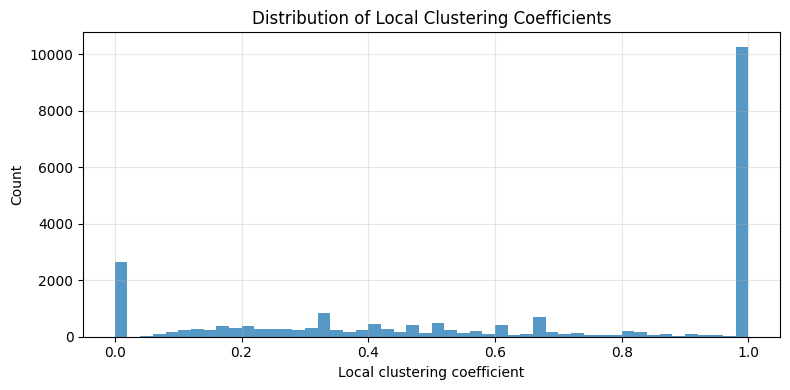

In [27]:
plt.figure(figsize=(8, 4))
plt.hist(clustering_values, bins=50, alpha=0.75)
plt.xlabel("Local clustering coefficient")
plt.ylabel("Count")
plt.title("Distribution of Local Clustering Coefficients")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Degree assortativity

Degree assortativity measures whether nodes tend to connect to others with similar degree. Collaboration networks are often assortative (high-degree authors preferentially connect to other high-degree authors).

In [28]:
deg_assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity coefficient:", deg_assortativity)

Degree assortativity coefficient: 0.13395498395287062


## 6. Connected components and giant component

We inspect the size distribution of connected components and focus on the largest one (the **giant component**), which typically contains the majority of authors.

We reuse the components as in the exploratory notebook, but here we will compute additional metrics restricted to the giant component.

In [29]:
components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]
component_sizes_sorted = sorted(component_sizes, reverse=True)

print("Number of connected components:", len(components))
print("Size of largest component:", component_sizes_sorted[0])
print("Size of 2nd largest component:", component_sizes_sorted[1] if len(component_sizes_sorted) > 1 else "-")

pd.DataFrame({"component_size": component_sizes_sorted[:10]})

Number of connected components: 567
Size of largest component: 21363
Size of 2nd largest component: 21


,component_size
0,21363
1,21
2,17
3,15
4,15
5,13
6,10
7,10
8,9
9,9


Now we extract the giant component and compute structural metrics specifically on this subgraph: average clustering and an approximate average shortest-path length (using sampling to reduce computational cost).

In [30]:
# Extract giant component
giant_nodes = max(components, key=len)
G_giant = G.subgraph(giant_nodes).copy()

print("Giant component:")
print("  Nodes:", G_giant.number_of_nodes())
print("  Edges:", G_giant.number_of_edges())

avg_clustering_giant = nx.average_clustering(G_giant)
print("Average clustering (giant component):", avg_clustering_giant)

# Approximate average shortest-path length using sampling
sample_size = 1000
sample_nodes = np.random.choice(list(G_giant.nodes()), size=min(sample_size, G_giant.number_of_nodes()), replace=False)

lengths = []
for i, u in enumerate(sample_nodes):
    sp_lengths = nx.single_source_shortest_path_length(G_giant, u)
    vals = [d for v, d in sp_lengths.items() if v != u]
    if vals:
        lengths.append(np.mean(vals))

approx_char_path_length = float(np.mean(lengths)) if lengths else float("nan")
print("Approximate average shortest-path length (giant component, sampled):", approx_char_path_length)

Giant component:
  Nodes: 21363
  Edges: 91286
Average clustering (giant component): 0.6417316374785165
Approximate average shortest-path length (giant component, sampled): 5.376260462503511


## 7. Centrality analysis (approximate betweenness)

To identify the most "central" authors in the giant component, we approximate the **betweenness centrality** using a sample of nodes. Exact betweenness can be expensive to compute on large graphs, so we use the `k`-node approximation available in NetworkX.

We then inspect the top-10 nodes ranked by approximate betweenness centrality and by degree for comparison.

In [31]:
k_sample = 100  # number of nodes used in approximation
print("Computing approximate betweenness centrality with k =", k_sample)

betw_approx = nx.betweenness_centrality(G_giant, k=k_sample, seed=42, normalized=True)

# Convert to DataFrame
df_betw = pd.DataFrame(
    [(node, val) for node, val in betw_approx.items()],
    columns=["node", "betweenness"]
)

df_betw_sorted = df_betw.sort_values("betweenness", ascending=False).reset_index(drop=True)
df_betw_sorted.head(10)

Computing approximate betweenness centrality with k = 100


,node,betweenness
0,15755,0.076075
1,4970,0.028918
2,11301,0.023513
3,21832,0.022994
4,16896,0.020016
5,19587,0.019727
6,6616,0.018988
7,21831,0.018907
8,1846,0.018592
9,19556,0.017281


For comparison, we also look at the top-10 nodes by degree in the giant component.

In [32]:
deg_giant = dict(G_giant.degree())
df_deg_giant = pd.DataFrame(
    [(node, d) for node, d in deg_giant.items()],
    columns=["node", "degree"]
)

df_deg_sorted = df_deg_giant.sort_values("degree", ascending=False).reset_index(drop=True)
df_deg_sorted.head(10)

,node,degree
0,15755,279
1,11301,252
2,16896,201
3,21051,190
4,5012,182
5,21832,165
6,21067,158
7,3351,148
8,9885,142
9,9875,138


We can also correlate degree and approximate betweenness for nodes in the giant component to understand whether high-degree authors are also central in terms of shortest-path traffic.

In [33]:
# Merge degree and betweenness for giant component nodes
df_centrality = df_deg_giant.merge(df_betw, on="node", how="left")
df_centrality["betweenness"] = df_centrality["betweenness"].fillna(0.0)

corr = df_centrality[["degree", "betweenness"]].corr()
corr

,degree,betweenness
degree,1.000000,0.588388
betweenness,0.588388,1.000000


We can also visualize the relationship between degree and betweenness using a scatter plot (in log–log scale) to see how centrality scales with degree.

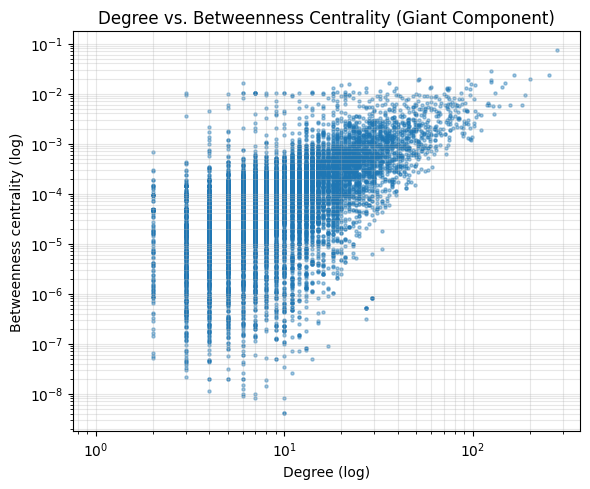

In [34]:
plt.figure(figsize=(6, 5))
plt.scatter(df_centrality["degree"], df_centrality["betweenness"], s=5, alpha=0.4)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (log)")
plt.ylabel("Betweenness centrality (log)")
plt.title("Degree vs. Betweenness Centrality (Giant Component)")
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Summary

In this notebook, we analyzed key structural properties of the collaboration network:

- **Degree distribution**: highly skewed, with a small number of high-degree authors and many authors with few collaborators. The CCDF in log–log scale is consistent with heavy-tailed behavior.
- **Clustering**: the network exhibits a high average clustering coefficient, reflecting strong triadic closure in co-authorship.
- **Degree assortativity**: we quantified the tendency of authors to collaborate with others of similar degree.
- **Connected components**: the network is dominated by a giant component that contains the vast majority of nodes, plus smaller components.
- **Shortest-path structure**: the approximate average path length in the giant component is relatively small, consistent with small-world properties.
- **Centrality**: approximate betweenness centrality identifies a set of structurally central authors, and we inspected its relationship with degree.

These findings support the modeling choices used in the link prediction experiments (e.g., the assumption of a large connected backbone, the importance of structural features, and the potential for GNNs to exploit clustering and community structure).

In [35]:
print('Notebook 02 finished successfully. 🚀')

Notebook 02 finished successfully. 🚀
